In [1]:
import pandas as pd

# csv_path = './datasets/MSR-Cambridge/proj_1.csv'
csv_path = './datasets/proj_1.csv'

headers = ['Timestamp','Hostname','DiskNumber','Type','Offset','Size','ResponseTime']
df = pd.read_csv(csv_path, header=None, names=headers)
print(df)

                   Timestamp Hostname  DiskNumber   Type        Offset   Size  \
0         128166372003314839     proj           1   Read  727328448000   4096   
1         128166372005807825     proj           1  Write  684887502336  20480   
2         128166372005809206     proj           1  Write  684887481856  20480   
3         128166372005810596     proj           1  Write  816422845952  65536   
4         128166372005810927     proj           1  Write  816422911488  65536   
...                      ...      ...         ...    ...           ...    ...   
23639737  128172419976106105     proj           1   Read  602082741760  65536   
23639738  128172419976262230     proj           1   Read  602082872832  65536   
23639739  128172419976418348     proj           1   Read  602082938368  65536   
23639740  128172419976425493     proj           1   Read  602083003904  13824   
23639741  128172419997366338     proj           1  Write  465114476032   4096   

          ResponseTime  
0 

In [8]:
from datetime import datetime,timedelta

def filetime_to_datetime(ts):
    if str(ts) == "0":
        return ""
    try:
        dt = datetime(1601, 1, 1) + timedelta(microseconds=ts / 10)
    except OverflowError:
        return ts
    return dt.timestamp()

df = df.loc[:, ['Timestamp', 'Type', 'Offset', 'Size']]
df['Timestamp'] = df['Timestamp'].map(filetime_to_datetime)
df['Type'] = df['Type'].map({'Read': 0, 'Write': 1})
df['Offset'] = df['Offset'].map(lambda x: x >> 14)
df.head()

,Timestamp,Type,Offset,Size
0,-1.164446e+10,NaN,2709,4096
1,-1.164446e+10,NaN,2551,20480
2,-1.164446e+10,NaN,2551,20480
3,-1.164446e+10,NaN,3041,65536
4,-1.164446e+10,NaN,3041,65536


In [10]:
processed = df.loc[:, ['Type', 'Offset', 'Size']]
processed.to_csv("proj_1_processed.csv", index=False, header=False)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


def plot(prediction, true):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(prediction)), prediction, color='b', marker='*')
    ax.plot(range(len(true)), true, color='r')
    plt.legend(['prediction', 'true'])
    plt.show()


class ELM():
    def __init__(self, input_nums, hidden_nums, output_nums):
        self.input_nums = input_nums
        self.hidden_nums = hidden_nums
        self.output_nums = output_nums
        self.is_inited = False

        # 隐层权重矩阵
        self.W = np.array([[np.random.uniform(-1, 1)
                          for _ in range(self.hidden_nums)] for i in range(self.input_nums)])
        # 隐层偏置项
        self.bias = np.array([np.random.uniform(-1, 1)
                             for _ in range(self.hidden_nums)])
        # 输出层权重
        self.beta = np.zeros(shape=[self.hidden_nums, self.output_nums])
        # (H^{T}H)^{-1}
        self.P = np.zeros(shape=[self.hidden_nums, self.hidden_nums])

    def predict(self, x):
        return np.dot(self.activation(np.dot(x, self.W) + self.bias), self.beta)

    def init_train(self, x, target):
        # output matrix
        H = self.activation(np.dot(x, self.W) + self.bias)
        HT = np.transpose(H)
        HTH = np.dot(HT, H)
        self.P = np.linalg.inv(HTH)
        pHT = np.dot(self.P, HT)
        self.beta = np.dot(pHT, target)
        self.is_inited = True

    def seq_train(self, x, target):
        batch_size = x.shape[0]
        H = self.activation(np.dot(x, self.W) + self.bias)
        HT = np.transpose(H)
        I = np.eye(batch_size)
        Hp = np.dot(H, self.P)
        HpHT = np.dot(Hp, HT)
        temp = np.linalg.inv(I + HpHT)
        pHT = np.dot(self.P, HT)
        self.P -= np.dot(np.dot(pHT, temp), Hp)
        pHT = np.dot(self.P, HT)
        Hbeta = np.dot(H, self.beta)
        self.beta += np.dot(pHT, target - Hbeta)

    def activation(self, x):
        return 1 / (1 + np.exp(-x))


In [4]:
window_size = 1000
scaler = MinMaxScaler()
# data = np.reshape(df['Type'].values, newshape=(-1, 1))
data = np.reshape(df['Offset'].values, newshape=(-1, 1))
# data = np.reshape(df['Size'].values, newshape=(-1, 1))
data = np.reshape(scaler.fit_transform(data), newshape=(-1, ))
print(data)

[0.82570122 0.77752003 0.77752001 ... 0.68351597 0.68351605 0.52802221]


In [5]:
X = []
Y = []
for i in range(len(data) - window_size):
    X.append(data[i:i + window_size])
    Y.append(data[i + window_size])

In [6]:
all_X = np.array(X[:5000000]) # num of X is: 23638742
all_Y = np.array(Y[:5000000])

In [7]:
train_X = all_X[:int(len(all_X) * 0.8), :]
train_Y = all_Y[:int(len(all_Y) * 0.8)]

test_X = all_X[int(len(all_X) * 0.8):, :]
test_Y = all_Y[int(len(all_Y) * 0.8):]

In [8]:
oselm = ELM(input_nums=1000, hidden_nums=64, output_nums=1)
oselm.init_train(train_X, train_Y)

In [9]:
prediction_list = []
Y_list = []

for X, Y in zip(test_X, test_Y):
    prediction = oselm.predict(X)
    prediction_list.append(prediction)
    Y_list.append(Y)

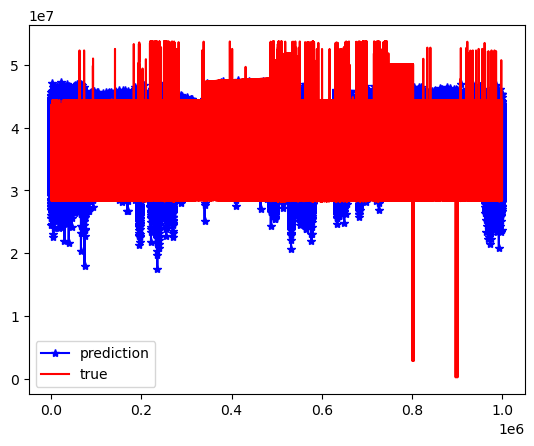

RMSE of ELM 6682552.756175235


In [10]:
prediction_arr = np.reshape(np.array(prediction_list), newshape=(-1, 1))
true_arr = np.reshape(np.array(Y_list), newshape=(-1, 1))
prediction_scaled_arr = scaler.inverse_transform(prediction_arr)
true_scaled_arr = scaler.inverse_transform(true_arr)
plot(prediction_scaled_arr, true_scaled_arr)
print('RMSE of ELM', np.sqrt(mean_squared_error(
    prediction_scaled_arr, true_scaled_arr)))

In [11]:
prediction_list = []
Y_list = []

for X, Y in zip(test_X, test_Y):
    prediction = oselm.predict(X)
    prediction_list.append(prediction)
    Y_list.append(Y)
    oselm.seq_train(X[np.newaxis, :], Y)


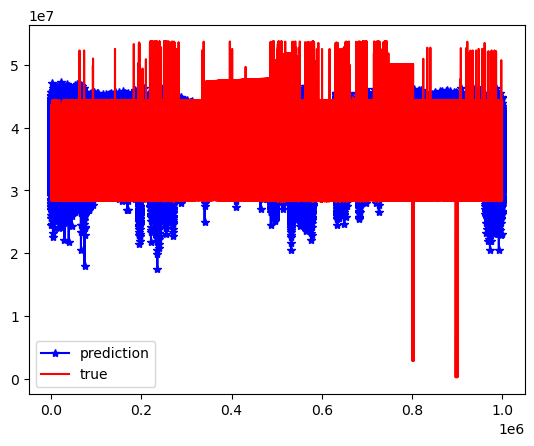

RMSE of OS-ELM 6629258.142499028


In [12]:
prediction_arr = np.reshape(np.array(prediction_list), newshape=(-1, 1))
true_arr = np.reshape(np.array(Y_list), newshape=(-1, 1))
prediction_scaled_arr = scaler.inverse_transform(prediction_arr)
true_scaled_arr = scaler.inverse_transform(true_arr)
plot(prediction_scaled_arr, true_scaled_arr)
print('RMSE of OS-ELM', np.sqrt(mean_squared_error(
    prediction_scaled_arr, true_scaled_arr)))